In [1]:
import numpy as np
from skimage.io import imread
from scipy.linalg import norm
from scipy.ndimage.filters import generic_filter, convolve
from scipy.signal import fftconvolve

In [2]:
from io import BytesIO
from PIL import Image as PIL_Image
import numpy as np
from IPython.display import display, Image

def display_img_array(ima, **kwargs):
    if ima.dtype == np.float32 or ima.dtype == np.float64:
        ima = (np.clip(ima, 0., 1.)*255).astype(np.uint8)
    im = PIL_Image.fromarray(ima) #[:,:,::-1])
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', **kwargs))

In [3]:
PSIZE = 65

(1331, 1054, 3)


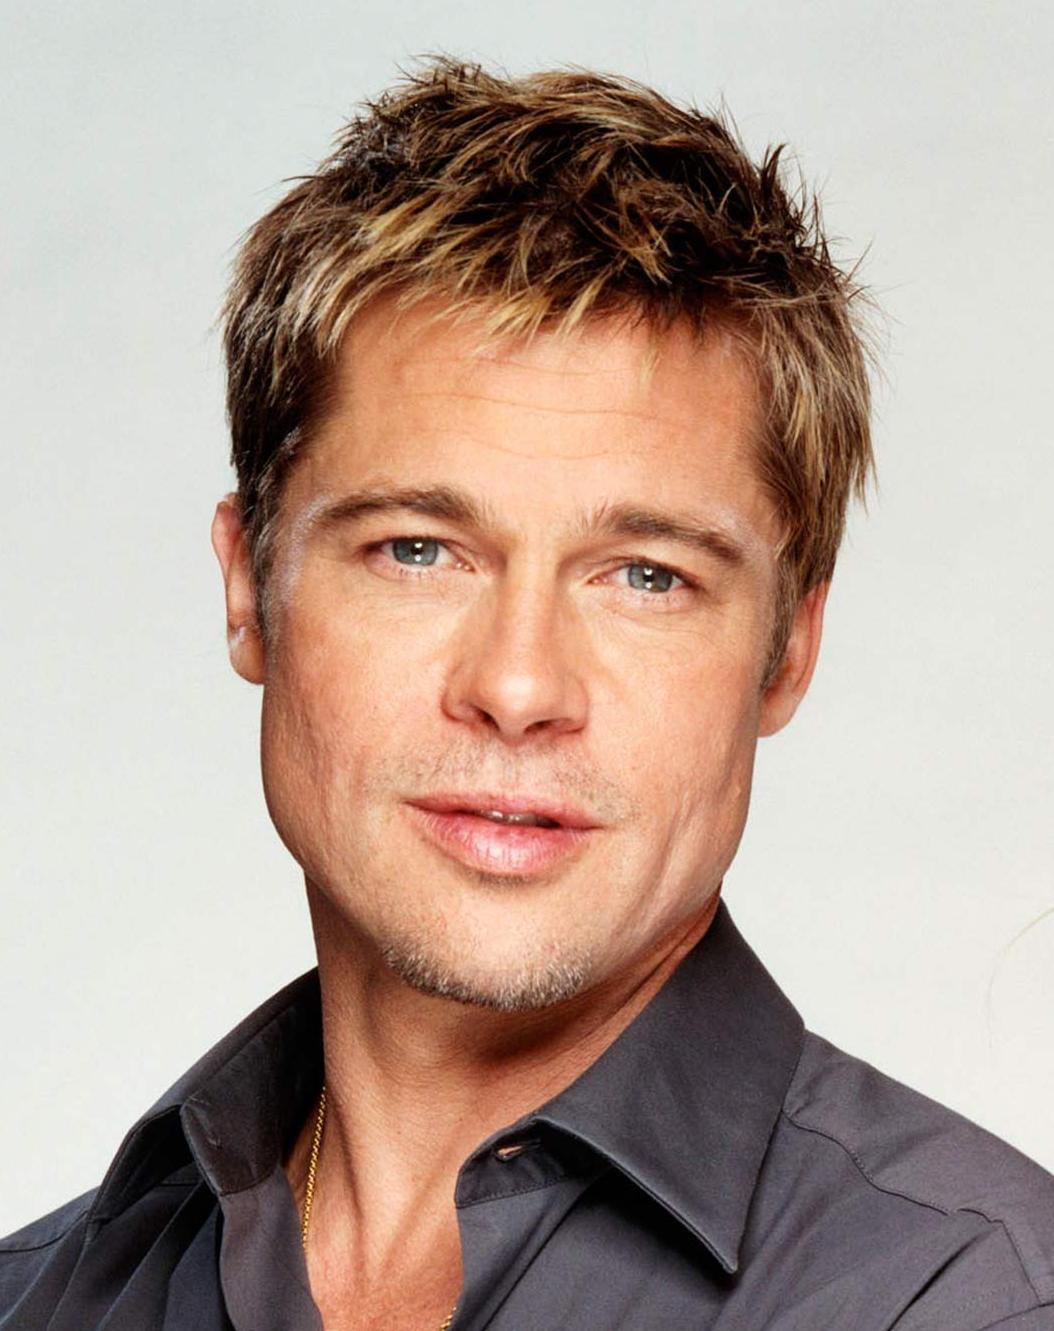

In [4]:
img0 = imread("img/brad_pitt.jpg")
print(img0.shape)
display_img_array(img0, width=400)

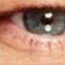

In [5]:
display_img_array(img0[530:530+PSIZE, 370:370+PSIZE])

In [6]:
img1 = imread("img/Pablo_Picasso1.jpg")

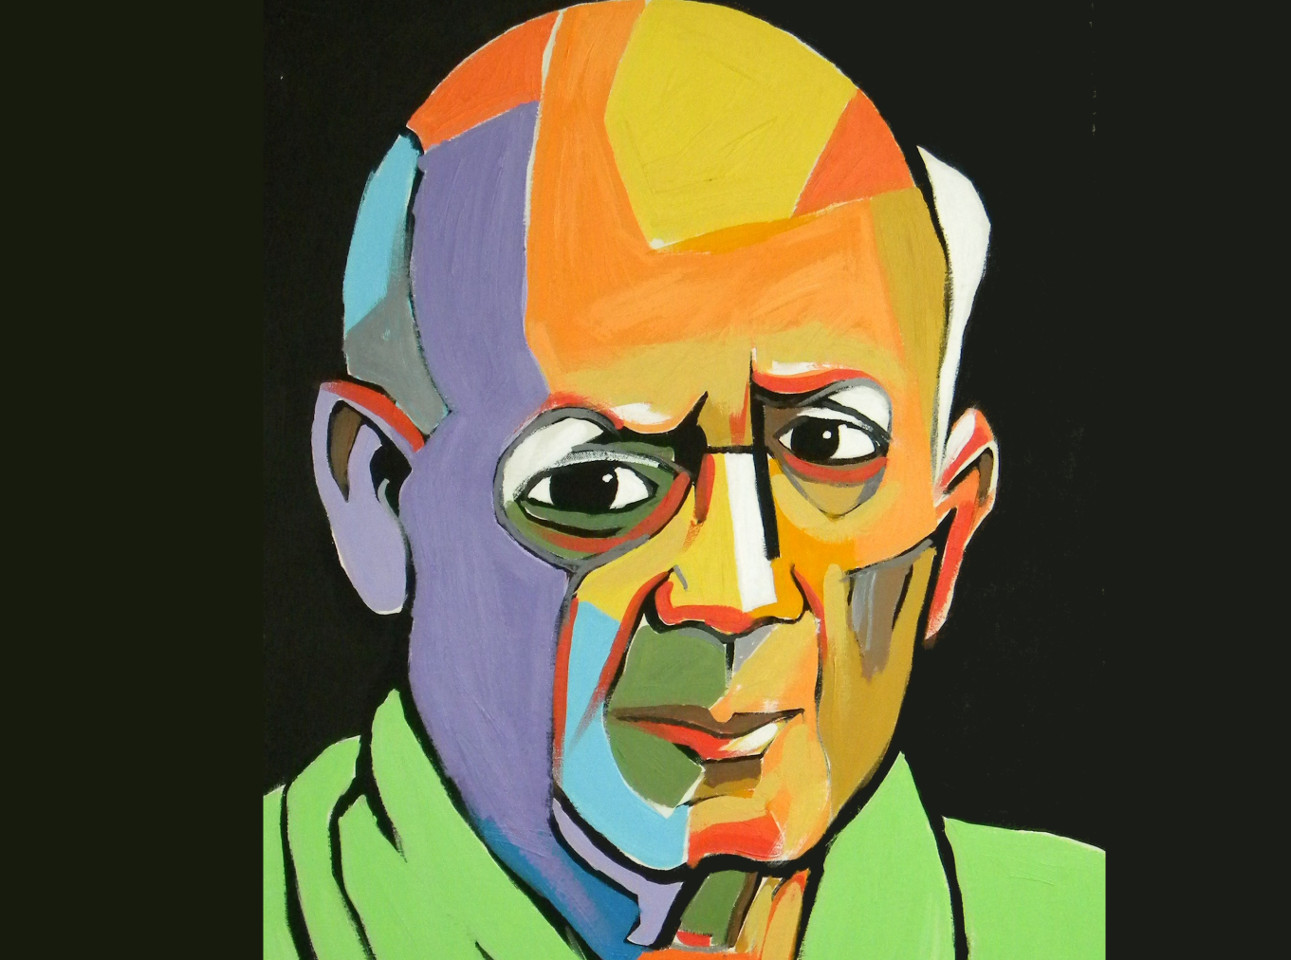

In [7]:
display_img_array(img1, width=400)

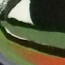

In [8]:
display_img_array(img1[480:480+PSIZE, 520:520+PSIZE])

In [9]:
img2 = img1.astype('float64')
img2 = img2 - np.mean(img2, axis=(0,1))

In [10]:
img3 = img0.astype('float64')
patch = img3[530:530+PSIZE, 370:370+PSIZE]-np.mean(img3, axis=(0,1))

In [27]:
%%timeit 
# conv
conv_square = np.square(img2)
conv_norm = np.sqrt(fftconvolve(np.sum(conv_square, axis=2), np.ones((PSIZE,PSIZE)), mode='valid'))[:-1,:-1]
#print((conv_norm-slow_norm).max())
def conv3(a, b):
    return [fftconvolve(a[:,:,i], b[:,:,i], mode='valid')[:-1,:-1] for i in range(3)]
conv_prod = sum(conv3(img2, patch[::-1,::-1]))
#print((conv_prod - slow_prod).max())
conv_corr = conv_prod / conv_norm
x,y = np.unravel_index(np.argmax(conv_corr), conv_corr.shape)

1 loops, best of 3: 408 ms per loop


480 551


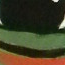

In [11]:
print(x,y)
display_img_array(img1[x:x+PSIZE, y:y+PSIZE])

In [14]:
import theano
import theano.tensor as T
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except:
    print("unable to import Conv2DDNNLayer, use Conv2DLayer instead")
    from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX
from lasagne.layers import *
import lasagne

In [16]:
theano.config.optimizer='fast_run'

In [17]:
def unwrap(a):
    return np.swapaxes(np.swapaxes(a[0],0,1),1,2)

In [18]:
imgx = floatX([np.swapaxes(np.swapaxes(img2, 1, 2), 0, 1)])

In [19]:
patchx = floatX([np.swapaxes(np.swapaxes(patch, 1, 2), 0, 1)])

In [20]:
input_img = T.tensor4()
layer_img = InputLayer((1, 3, None, None), input_var=input_img)
layer_sqr_sum = ExpressionLayer(layer_img,  lambda x:T.sum(T.sqr(x), axis=1,keepdims=True) , output_shape=(1,1,None,None))
layer_norm = ConvLayer(layer_sqr_sum, 1, PSIZE, pad='valid', W=floatX(np.ones((1, 1, PSIZE,PSIZE))), b=None, nonlinearity=T.sqrt)

In [21]:
rtn =get_output(layer_norm).eval({input_img: imgx}) [0,0][:-1,:-1]
(rtn - conv_norm).max()

0.11466318837756262

In [22]:
input_patch = T.tensor4()
layer_prod= ConvLayer(layer_img, 1, PSIZE, pad='valid', W=input_patch, b=None, nonlinearity=None)
layer_corr = ElemwiseMergeLayer([layer_prod, layer_norm], lambda a,b: a/b)
layer_corr_output = lasagne.layers.get_output(layer_corr)

In [1]:
best_match = theano.function([input_img, input_patch], T.max_and_argmax(layer_corr_output)+[T.shape(layer_corr_output)])

NameError: name 'theano' is not defined

3885.37939453125 [   1    1  896 1227] (480, 551)


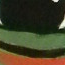

In [25]:
m, i, s = best_match(imgx, patchx)
x, y = np.unravel_index(i,s[2:])
print(m, s, (x,y))
display_img_array(img1[x:x+PSIZE, y:y+PSIZE])

In [26]:
%%timeit
best_match(imgx, patchx)

1 loops, best of 3: 444 ms per loop
